In [15]:
# import the required librarires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve
)
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier




In [16]:
# Load the dataset
df = pd.read_csv(r"C:\Users\SOUMIK DASH\Documents\M.Sc Sem 4\project\nfhs_child_mortality_project.csv")

In [17]:
df.head()

,caseid,mother_age,education_level,wealth_index,place_of residence,religion,caste,contraceptive_method,marital_status,total_children_ever_born,...,mother_birth_date_cm,child_birth_date_cm,child_alive,age_at_death,age_at_death_months,preceding_birth_interval,birth_order,child_sex,event,duration
0,0100103022 04,29,2,5,2,2,991,3,1,1,...,1083,1382,1,NaN,NaN,NaN,1,1,0,58
1,0100103033 02,36,1,3,2,2,991,3,1,4,...,1002,1374,1,NaN,NaN,25.0,4,2,0,66
2,0100100997 02,48,0,3,2,2,992,0,1,2,...,855,1103,1,NaN,NaN,20.0,2,1,0,336
3,0100100966 02,39,2,2,2,2,991,2,1,4,...,966,1263,1,NaN,NaN,24.0,5,1,0,176
4,0100100914 02,31,2,4,2,2,992,3,1,2,...,1062,1410,1,NaN,NaN,31.0,2,2,0,29


##BASIC DESCRIPTIVE STUDY

In [18]:
# Rename column for consistency
df.rename(columns={"place_of residence": "place_of_residence"}, inplace=True)

In [19]:
# Set up visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

##========== Basic Overview ==========

In [20]:
print("🔹 First 5 Rows:\n", df.head())
print("\n🔹 Shape of the Dataset:", df.shape)
print("\n🔹 Dataset Info:\n")
df.info()
print("\n🔹 Summary Statistics:\n", df.describe(include="all"))

🔹 First 5 Rows:
             caseid  mother_age  education_level  wealth_index  \
0    0100103022 04          29                2             5   
1    0100103033 02          36                1             3   
2    0100100997 02          48                0             3   
3    0100100966 02          39                2             2   
4    0100100914 02          31                2             4   

   place_of_residence  religion  caste  contraceptive_method  marital_status  \
0                   2         2    991                     3               1   
1                   2         2    991                     3               1   
2                   2         2    992                     0               1   
3                   2         2    991                     2               1   
4                   2         2    992                     3               1   

   total_children_ever_born  ...  mother_birth_date_cm  child_birth_date_cm  \
0                         1  ...

In [21]:
# Missing values
print("\n❗ Missing Values:\n")
print(df.isnull().sum())


❗ Missing Values:

caseid                           0
mother_age                       0
education_level                  0
wealth_index                     0
place_of_residence               0
religion                         0
caste                            0
contraceptive_method             0
marital_status                   0
total_children_ever_born         0
interview_date_cm                0
mother_birth_date_cm             0
child_birth_date_cm              0
child_alive                      0
age_at_death                129437
age_at_death_months         129437
preceding_birth_interval     53372
birth_order                      0
child_sex                        0
event                            0
duration                         0
dtype: int64


In [22]:
# Categorical value counts
categorical_cols = [
    "education_level", "wealth_index", "place_of_residence",
    "religion", "caste", "contraceptive_method", "marital_status"
]

print("\n📋 Categorical Column Distributions:\n")
for col in categorical_cols:
    print(f"\n{col}:\n{df[col].value_counts(dropna=False)}")


📋 Categorical Column Distributions:


education_level:
education_level
2    54013
0    52644
1    22223
3     8772
Name: count, dtype: int64

wealth_index:
wealth_index
1    34364
2    32766
3    28257
4    23793
5    18472
Name: count, dtype: int64

place_of_residence:
place_of_residence
2    107757
1     29895
Name: count, dtype: int64

religion:
religion
1     102908
2      17508
3      10889
4       2610
96      1907
5       1627
6        131
9         60
8         11
7          1
Name: count, dtype: int64

caste:
caste
991    108638
992     21924
993      6362
998       728
Name: count, dtype: int64

contraceptive_method:
contraceptive_method
3    88974
0    32351
2    16327
Name: count, dtype: int64

marital_status:
marital_status
1    137652
Name: count, dtype: int64


##Data Cleaning

Create new columns

In [23]:
# mother & child age at interview

df["mother_age_at_interview"] = df["interview_date_cm"] - df["mother_birth_date_cm"]
df["child_age_at_interview"] = df["interview_date_cm"] - df["child_birth_date_cm"]

Drop unnecessary or leakage-prone columns

In [24]:
df.drop([
    "interview_date_cm",
    "mother_birth_date_cm",
    "child_birth_date_cm",
    "age_at_death",
    "age_at_death_months",
    "duration",
    "event"  # because it's survival-specific
], axis=1, inplace=True)

In [25]:
# Drop rows with missing target value if any
df = df.dropna(subset=['child_alive'])

Handle missing values

In [26]:
# For preceding_birth_interval:
# Set to 0 where birth_order is 1
df['preceding_birth_interval'] = df.apply(
    lambda row: 0 if row['birth_order'] == 1 else row['preceding_birth_interval'],
    axis=1
)


In [27]:
# Handle missing values (basic option: fill with "Missing")
categorical_cols = [
    "education_level", "wealth_index", "place_of_residence",
    "religion", "caste", "contraceptive_method", "marital_status"
]

for col in categorical_cols:
    df[col] = df[col].fillna("Missing")


In [28]:
# Fill any remaining NaNs with median
df['preceding_birth_interval'] = df['preceding_birth_interval'].fillna(df['preceding_birth_interval'].median())



Confirm cleanup so far

In [29]:

print("🔹 Shape:", df.shape)
print("🔹 Missing values:\n", df.isnull().sum())

🔹 Shape: (137652, 16)
🔹 Missing values:
 caseid                      0
mother_age                  0
education_level             0
wealth_index                0
place_of_residence          0
religion                    0
caste                       0
contraceptive_method        0
marital_status              0
total_children_ever_born    0
child_alive                 0
preceding_birth_interval    0
birth_order                 0
child_sex                   0
mother_age_at_interview     0
child_age_at_interview      0
dtype: int64


In [30]:
# peek at the data
print("\n🔹 First 5 rows:\n")
df.head()


🔹 First 5 rows:



,caseid,mother_age,education_level,wealth_index,place_of_residence,religion,caste,contraceptive_method,marital_status,total_children_ever_born,child_alive,preceding_birth_interval,birth_order,child_sex,mother_age_at_interview,child_age_at_interview
0,0100103022 04,29,2,5,2,2,991,3,1,1,1,0.0,1,1,357,58
1,0100103033 02,36,1,3,2,2,991,3,1,4,1,25.0,4,2,438,66
2,0100100997 02,48,0,3,2,2,992,0,1,2,1,20.0,2,1,584,336
3,0100100966 02,39,2,2,2,2,991,2,1,4,1,24.0,5,1,473,176
4,0100100914 02,31,2,4,2,2,992,3,1,2,1,31.0,2,2,377,29


## EDA - Univariate Analysis

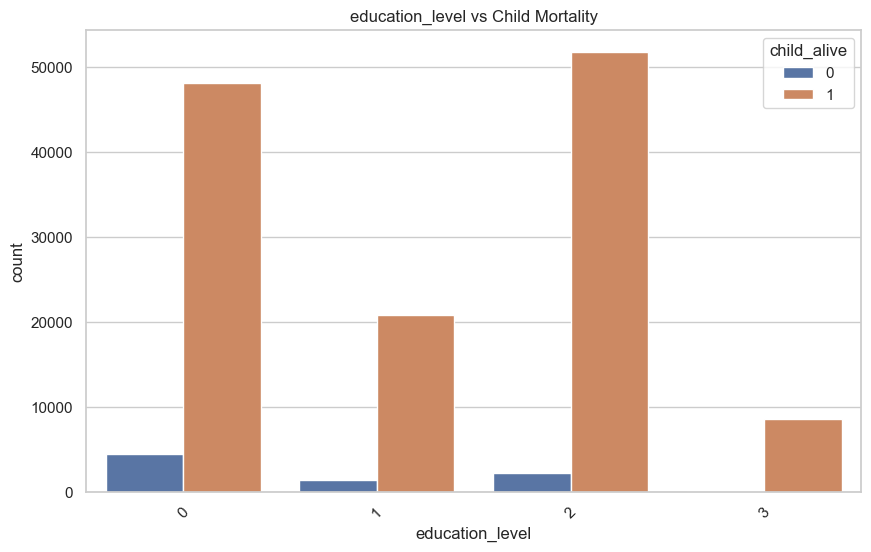

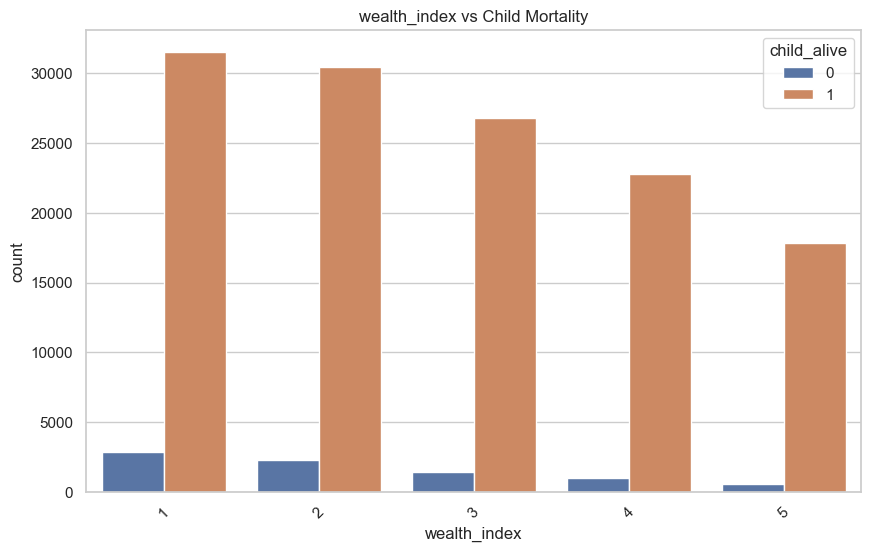

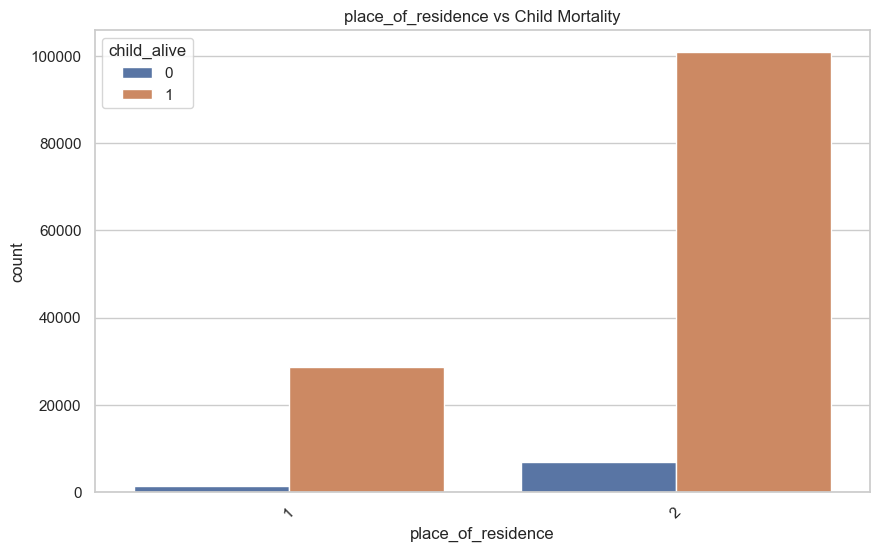

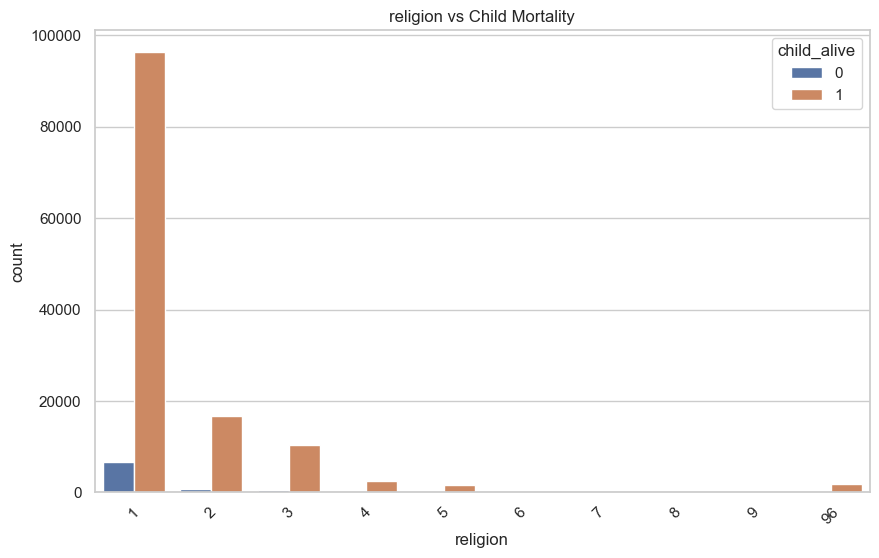

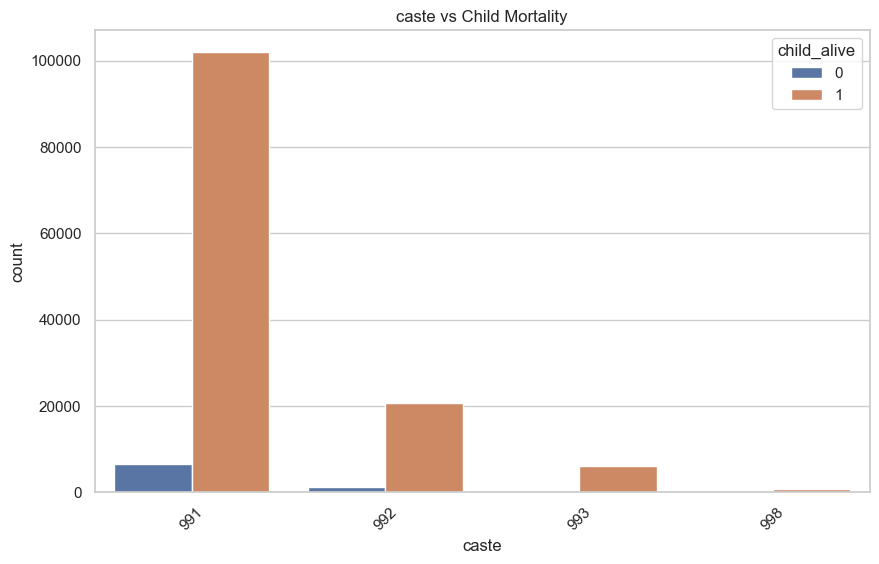

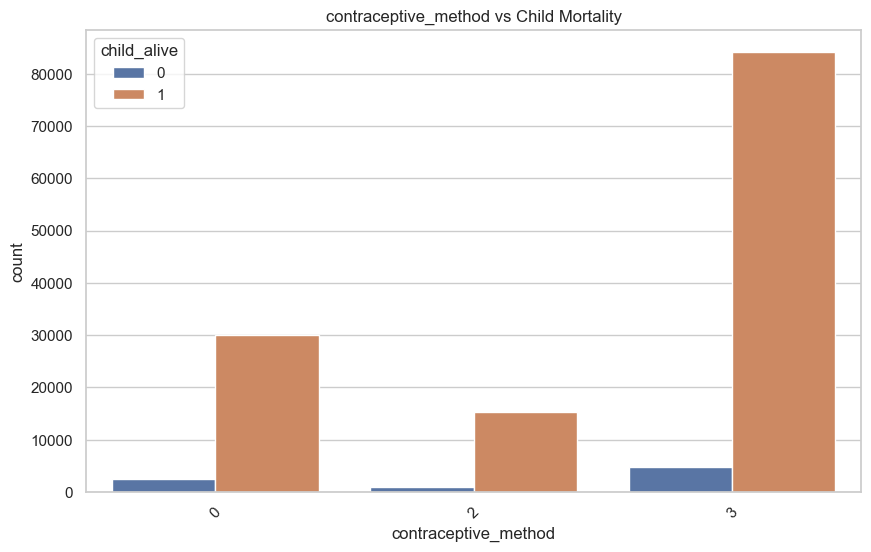

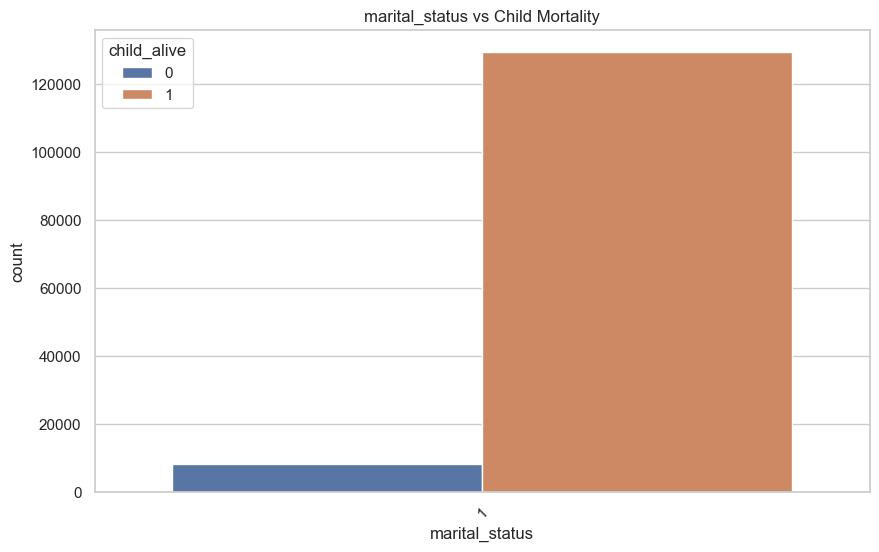

In [31]:
# Function to plot categorical features
def plot_cat(col):
    sns.countplot(data=df, x=col, hue="child_alive")
    plt.title(f"{col} vs Child Mortality")
    plt.xticks(rotation=45)
    plt.show()

for col in categorical_cols:
    plot_cat(col)

EDA - Numeric Features

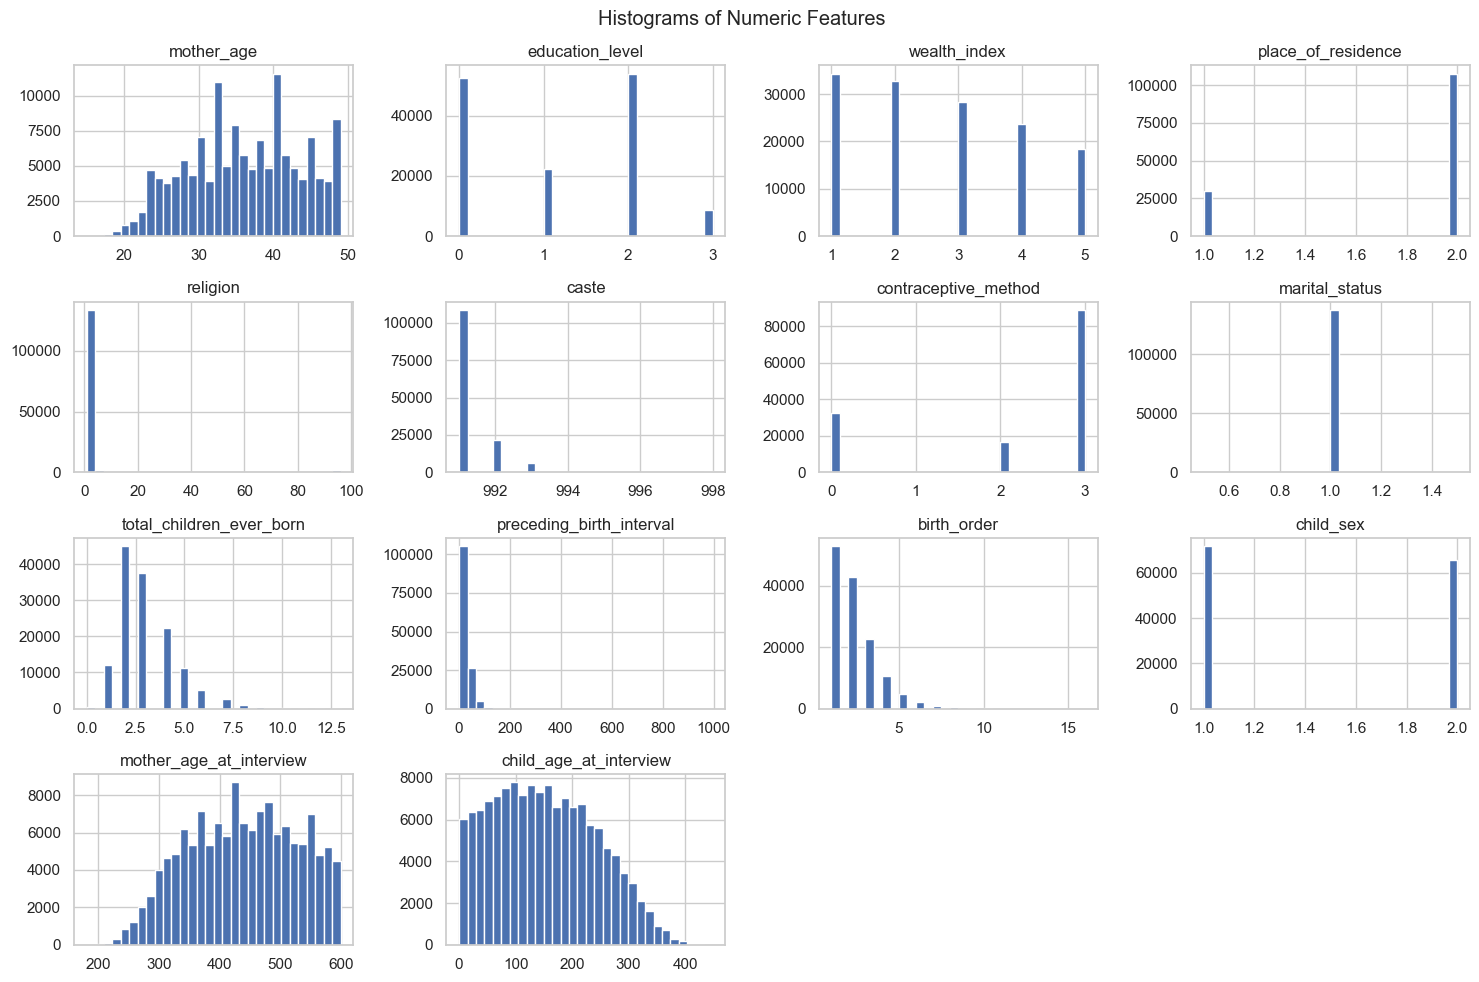

In [32]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('child_alive')  # exclude target

# Histograms for numerical features
df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Features")
plt.tight_layout()
plt.show()

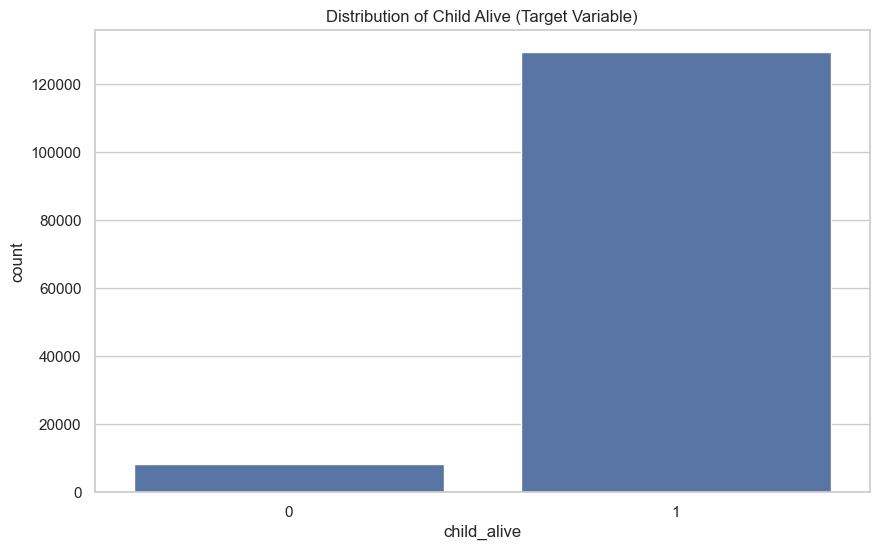

In [33]:
target_col = 'child_alive'
sns.countplot(x=target_col, data=df)
plt.title("Distribution of Child Alive (Target Variable)")
plt.show()


In [34]:
print("\nTarget Value Counts:\n", df[target_col].value_counts())


Target Value Counts:
 child_alive
1    129437
0      8215
Name: count, dtype: int64


As all the column as not numeric although they have numbers


In [35]:
true_numeric_cols = [
    'mother_age',                  # Continuous
    'mother_age_at_interview',    # Derived from date columns
    'child_age_at_interview',     # Derived from date columns
    'total_children_ever_born',        # Count
    'birth_order',                # Count of child
    'preceding_birth_interval'    # Gap between children in months
    # Add more if any emerge during modeling
]

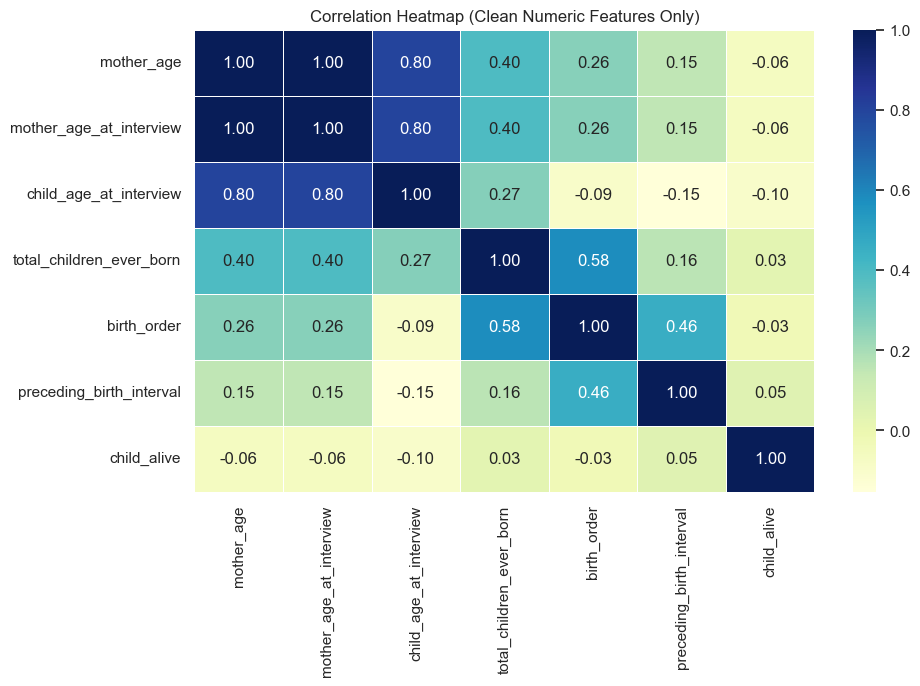

In [36]:
# Correlation Heatmap on valid continuous features
plt.figure(figsize=(10, 6))
corr = df[true_numeric_cols + ['child_alive']].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Correlation Heatmap (Clean Numeric Features Only)")
plt.show()

As mother_age and mother_age_at_interview are perfectly correlated we drop one of the columns and also we remove the caseid column

In [37]:
# Drop the redundant column
df.drop(columns=['mother_age_at_interview','caseid'], inplace=True)

In [38]:
df.head()

,mother_age,education_level,wealth_index,place_of_residence,religion,caste,contraceptive_method,marital_status,total_children_ever_born,child_alive,preceding_birth_interval,birth_order,child_sex,child_age_at_interview
0,29,2,5,2,2,991,3,1,1,1,0.0,1,1,58
1,36,1,3,2,2,991,3,1,4,1,25.0,4,2,66
2,48,0,3,2,2,992,0,1,2,1,20.0,2,1,336
3,39,2,2,2,2,991,2,1,4,1,24.0,5,1,176
4,31,2,4,2,2,992,3,1,2,1,31.0,2,2,29


Outlier Detection

In [39]:
true_numeric_cols_updated = [
    'mother_age',                  # Continuous
    'child_age_at_interview',     # Derived from date columns
    'total_children_ever_born',        # Count
    'birth_order',                # Count of child
    'preceding_birth_interval'    # Gap between children in months
    # Add more if any emerge during modeling
]

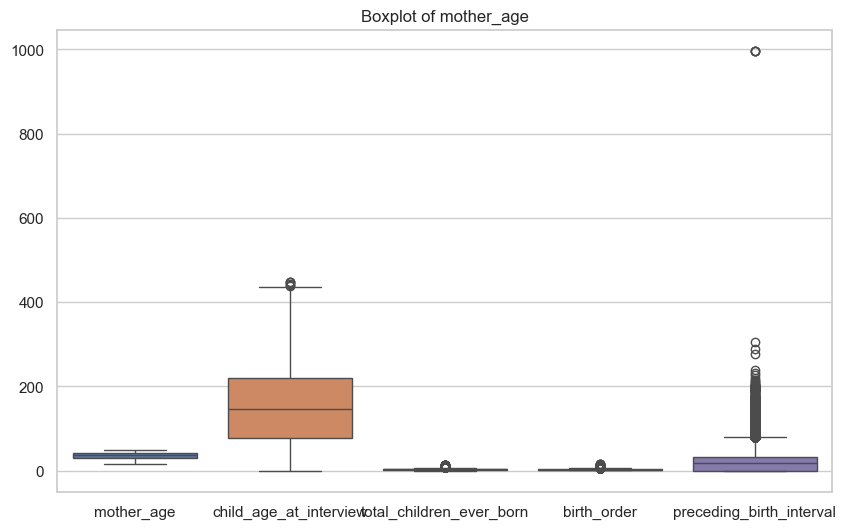

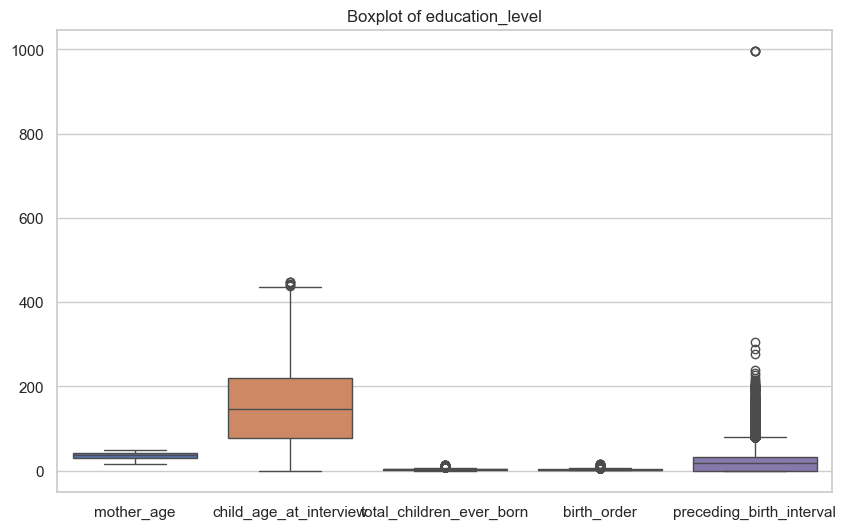

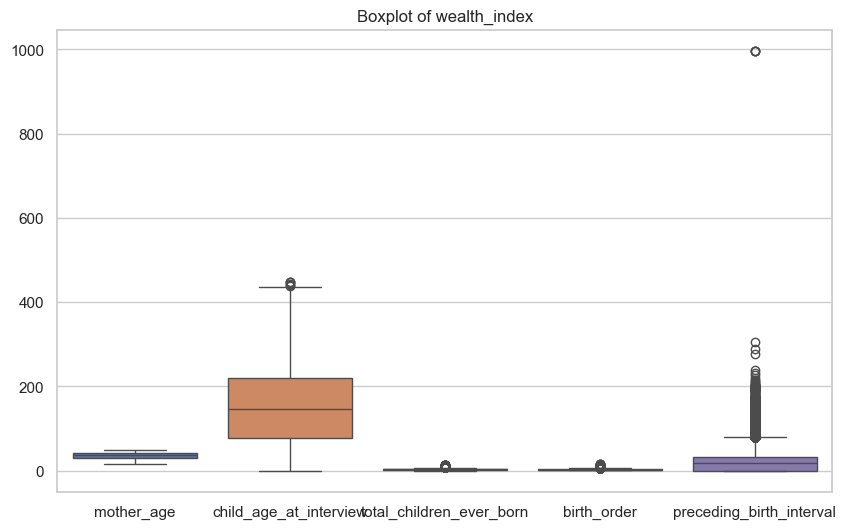

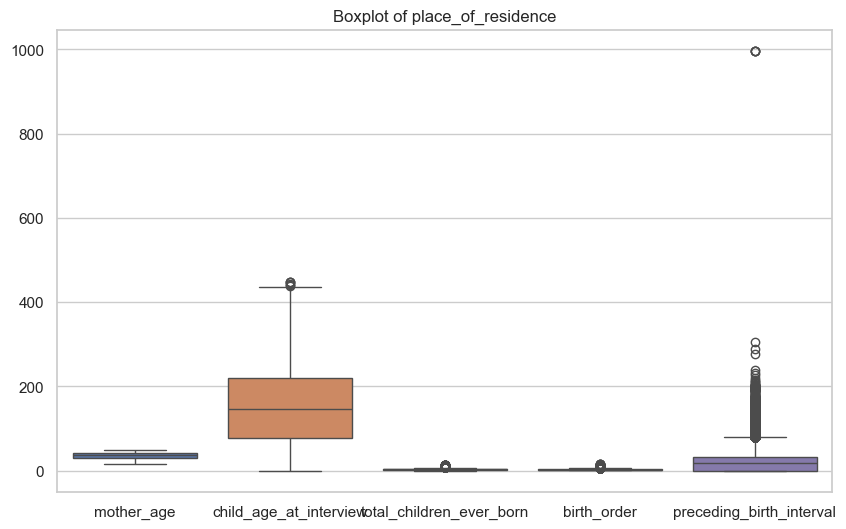

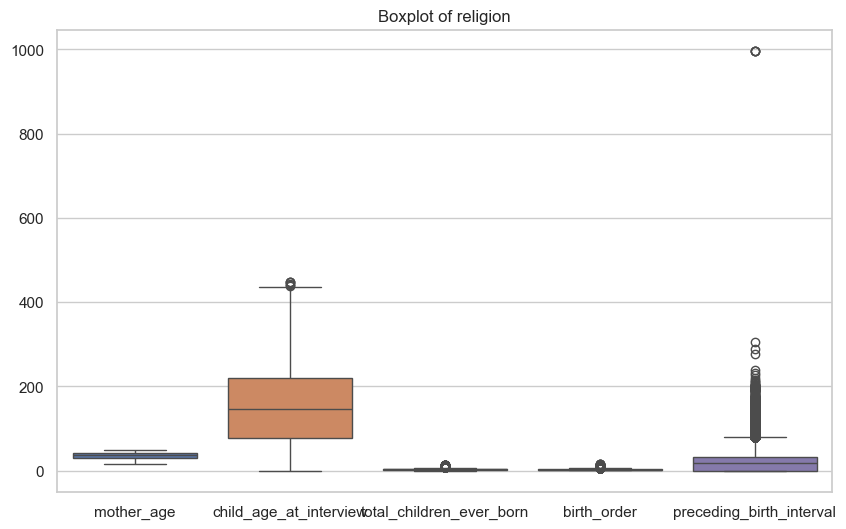

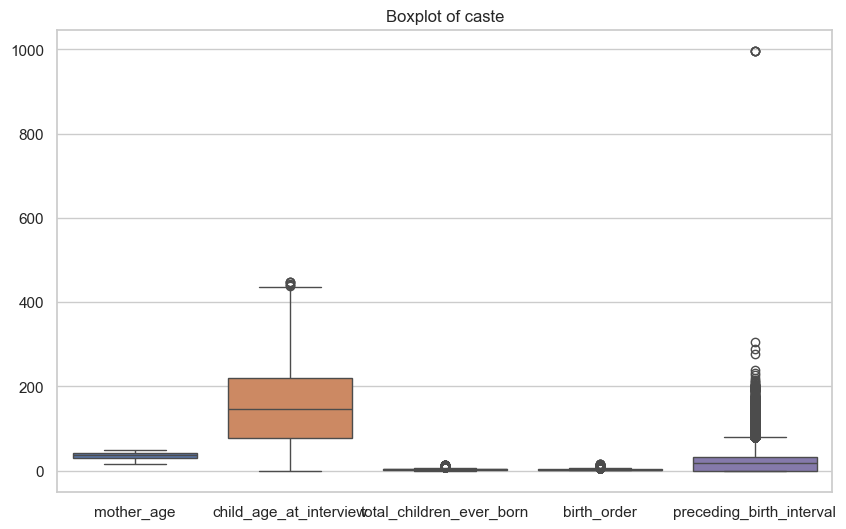

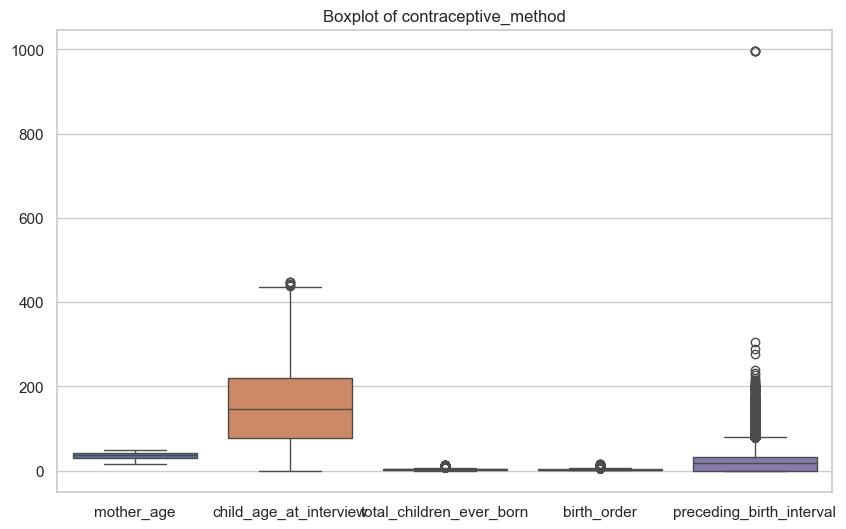

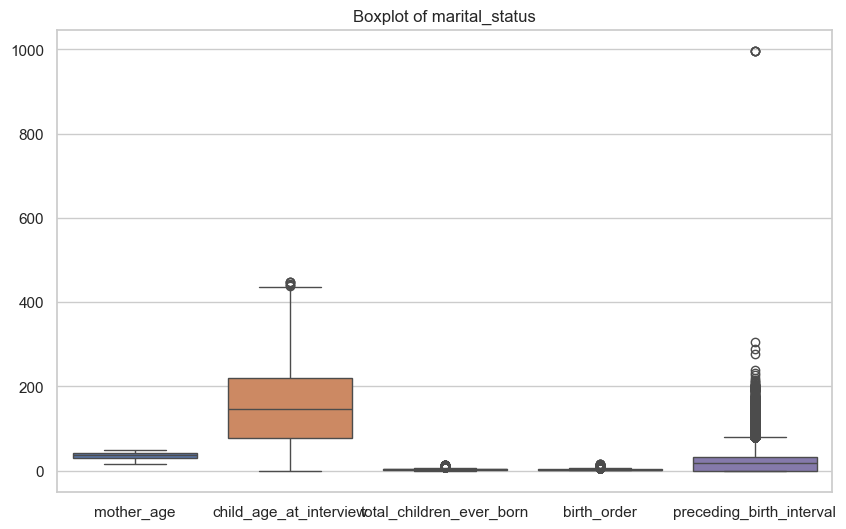

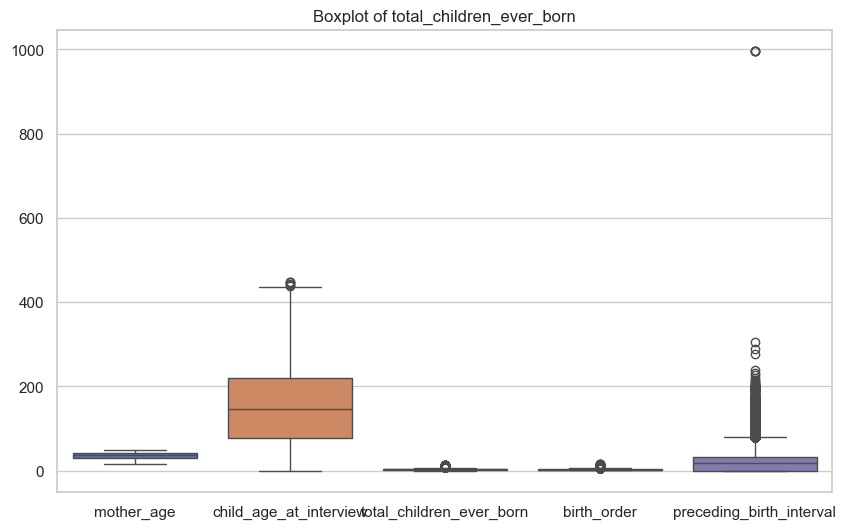

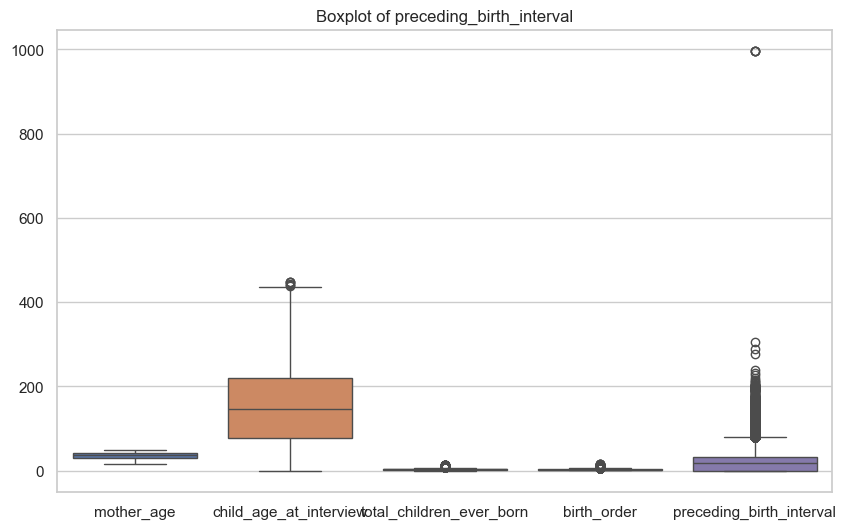

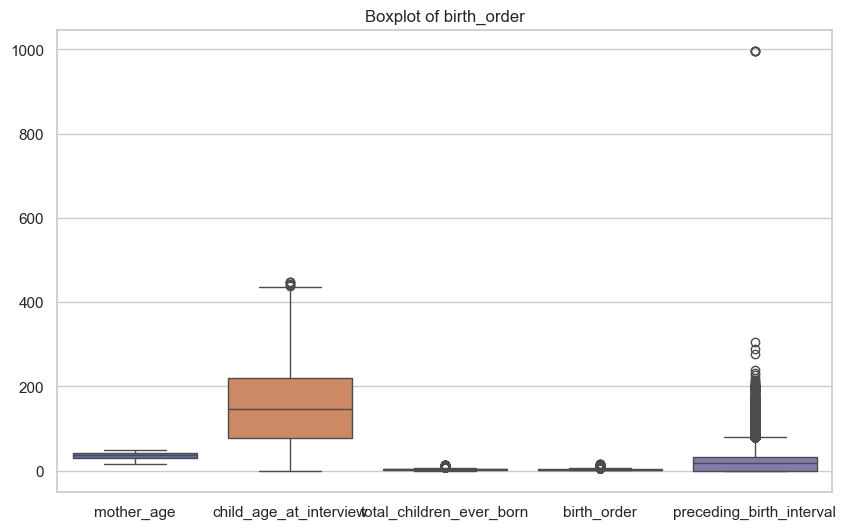

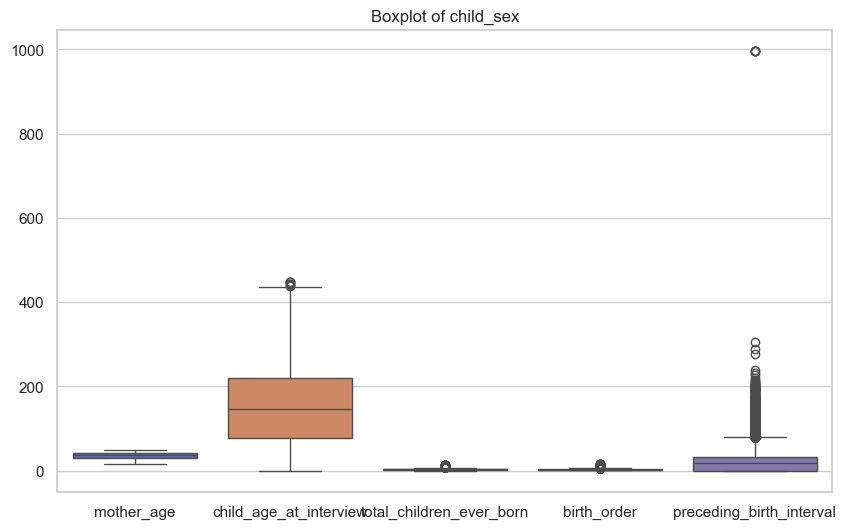

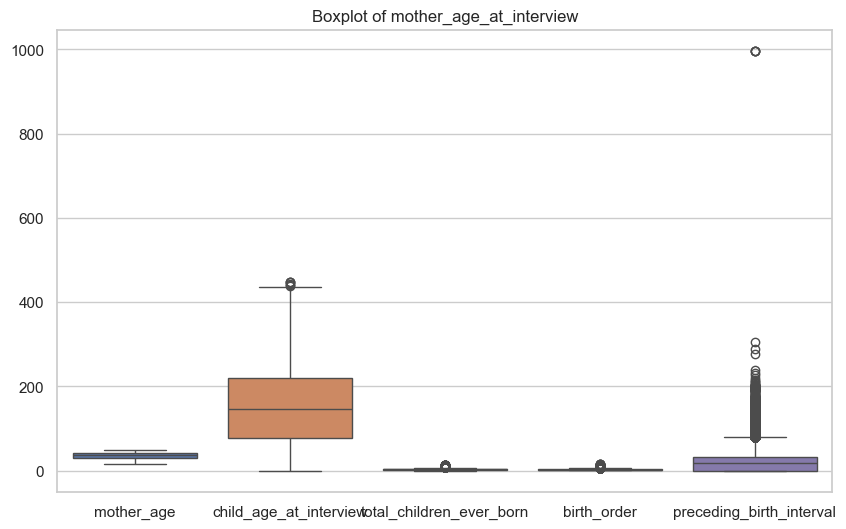

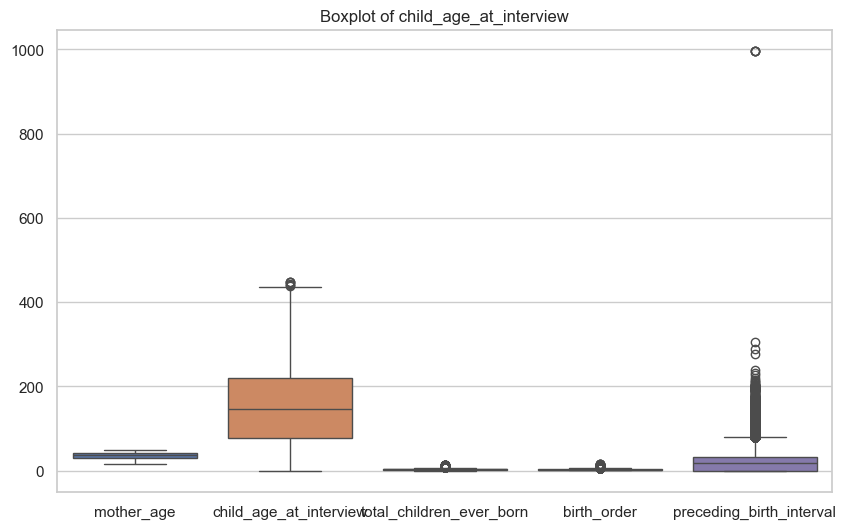

In [40]:
for col in numeric_cols:
    sns.boxplot(data=df[true_numeric_cols_updated])
    plt.title(f"Boxplot of {col}")
    plt.show()


##Data Encoding

In [41]:
# Mapping dictionaries
education_map = {0: 'No Education', 1: 'Primary', 2: 'Secondary', 3: 'Higher', 9: np.nan}
wealth_map = {1: 'Poorest', 2: 'Poorer', 3: 'Middle', 4: 'Richer', 5: 'Richest'}
place_map = {1: 'Urban', 2: 'Rural'}
religion_map = {1: 'Hindu', 2: 'Muslim', 3: 'Christian', 4: 'Sikh', 5: 'Buddhist',
                6: 'Jain', 7: 'Jewish', 8: 'Parsi', 9: 'No religion', 96: 'Other'}
caste_map = {991: 'Caste', 992: 'Tribe', 993: 'No Caste', 998: np.nan}
contraceptive_map = {0: 'No Method', 1: 'Folkloric', 2: 'Traditional', 3: 'Modern', 9: np.nan}
marital_map = {0: 'Never in union', 1: 'Currently in union', 2: 'Formerly in union', 9: np.nan}
sex_map = {1: 'Male', 2: 'Female'}

# Apply mappings
df['education_level'] = df['education_level'].map(education_map)
df['wealth_index'] = df['wealth_index'].map(wealth_map)
df['place_of_residence'] = df['place_of_residence'].map(place_map)
df['religion'] = df['religion'].map(religion_map)
df['caste'] = df['caste'].map(caste_map)
df['contraceptive_method'] = df['contraceptive_method'].map(contraceptive_map)
df['marital_status'] = df['marital_status'].map(marital_map)
df['child_sex'] = df['child_sex'].map(sex_map)


Identify the Type of Categorical Columns

In [42]:
# Ordinal Features (can use LabelEncoder)
ordinal_cols = ['education_level', 'wealth_index']

# Nominal Features (use one-hot encoding)
nominal_cols = ['place_of_residence', 'religion', 'caste', 'contraceptive_method', 'marital_status', 'child_sex']


Encode Ordinal with LabelEncoder

In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ordinal_cols:
    df[col] = le.fit_transform(df[col])

One-Hot Encode Nominal Columns

In [44]:
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

In [45]:
df.head()

,mother_age,education_level,wealth_index,total_children_ever_born,child_alive,preceding_birth_interval,birth_order,child_age_at_interview,place_of_residence_Urban,religion_Christian,...,religion_Muslim,religion_No religion,religion_Other,religion_Parsi,religion_Sikh,caste_No Caste,caste_Tribe,contraceptive_method_No Method,contraceptive_method_Traditional,child_sex_Male
0,29,3,4,1,1,0.0,1,58,False,False,...,True,False,False,False,False,False,False,False,False,True
1,36,2,0,4,1,25.0,4,66,False,False,...,True,False,False,False,False,False,False,False,False,False
2,48,1,0,2,1,20.0,2,336,False,False,...,True,False,False,False,False,False,True,True,False,True
3,39,3,1,4,1,24.0,5,176,False,False,...,True,False,False,False,False,False,False,False,True,True
4,31,3,3,2,1,31.0,2,29,False,False,...,True,False,False,False,False,False,True,False,False,False


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137652 entries, 0 to 137651
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   mother_age                        137652 non-null  int64  
 1   education_level                   137652 non-null  int32  
 2   wealth_index                      137652 non-null  int32  
 3   total_children_ever_born          137652 non-null  int64  
 4   child_alive                       137652 non-null  int64  
 5   preceding_birth_interval          137652 non-null  float64
 6   birth_order                       137652 non-null  int64  
 7   child_age_at_interview            137652 non-null  int64  
 8   place_of_residence_Urban          137652 non-null  bool   
 9   religion_Christian                137652 non-null  bool   
 10  religion_Hindu                    137652 non-null  bool   
 11  religion_Jain                     137652 non-null  b

In [47]:
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137652 entries, 0 to 137651
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   mother_age                        137652 non-null  int64  
 1   education_level                   137652 non-null  int32  
 2   wealth_index                      137652 non-null  int32  
 3   total_children_ever_born          137652 non-null  int64  
 4   child_alive                       137652 non-null  int64  
 5   preceding_birth_interval          137652 non-null  float64
 6   birth_order                       137652 non-null  int64  
 7   child_age_at_interview            137652 non-null  int64  
 8   place_of_residence_Urban          137652 non-null  int32  
 9   religion_Christian                137652 non-null  int32  
 10  religion_Hindu                    137652 non-null  int32  
 11  religion_Jain                     137652 non-null  i

Variance Inflation Factor (VIF)

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Prepare features (exclude target)
X_vif = df.drop(columns='child_alive')

# Add constant term for statsmodels
X_vif_const = add_constant(X_vif)

# Create a DataFrame for VIF values
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_const.values, i + 1) for i in range(len(X_vif.columns))]

print(vif_data.sort_values(by='VIF', ascending=False))


                             feature        VIF
9                     religion_Hindu  16.605599
12                   religion_Muslim  10.681699
8                 religion_Christian   7.236493
6             child_age_at_interview   4.664430
0                         mother_age   4.609791
16                     religion_Sikh   2.626191
5                        birth_order   2.427011
14                    religion_Other   2.159332
3           total_children_ever_born   1.965499
18                       caste_Tribe   1.558934
4           preceding_birth_interval   1.413288
2                       wealth_index   1.145467
7           place_of_residence_Urban   1.142330
17                    caste_No Caste   1.128911
19    contraceptive_method_No Method   1.095511
10                     religion_Jain   1.084503
1                    education_level   1.083370
20  contraceptive_method_Traditional   1.065304
13              religion_No religion   1.036697
21                    child_sex_Male   1

Feature Scaling

In [50]:
from sklearn.preprocessing import StandardScaler

# Select numeric continuous features (excluding dummies and target)
continuous_cols = ['mother_age', 'total_children_ever_born', 'birth_order', 'preceding_birth_interval', 'child_age_at_interview']

# Initialize scaler
scaler = StandardScaler()

# Fit and transform
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])


Train-Test Split

In [51]:
from sklearn.model_selection import train_test_split

# Define feature columns (X) and target column (y)
X = df.drop("child_alive", axis=1)
y = df["child_alive"]

# Flip y so that 1 = Death, 0 = Alive
y = 1 - y


# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train-Test Split Done")
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Train-Test Split Done
Training Set Shape: (110121, 22)
Testing Set Shape: (27531, 22)


Apply SMOTE on training set

In this project, the target variable child_alive was found to be highly imbalanced, with a much higher number of children surviving compared to those who did not. Training a machine learning model on such imbalanced data can bias the predictions towards the majority class, leading to poor performance on the minority class — which, in this case, is critical to detect accurately.

To address this issue, the SMOTE (Synthetic Minority Oversampling Technique) algorithm was used. SMOTE works by generating synthetic examples of the minority class based on the existing data. Instead of simply duplicating existing examples, it creates new, slightly varied samples by interpolating between existing minority class instances. This helps the model learn the patterns of both classes more effectively.

Importantly, SMOTE was applied only to the training data after performing the train-test split. This ensures that the test data remains untouched and representative of the original distribution, which is crucial for unbiased model evaluation.

Using SMOTE significantly improved the model’s ability to detect the minority class, as reflected in improved recall and F1-scores across multiple models.



In [52]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#Check class distribution before and after SMOTE
print("🔹 Before SMOTE:")
print(y_train.value_counts())
print("\n🔹 After SMOTE:")
print(y_train_resampled.value_counts())

🔹 Before SMOTE:
child_alive
0    103549
1      6572
Name: count, dtype: int64

🔹 After SMOTE:
child_alive
0    103549
1    103549
Name: count, dtype: int64


### Model Fitting & Evaluation

Logistic Regression

Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Cross-Validation Accuracy Scores: [0.66721391 0.67938194 0.67979237 0.67572853 0.68067795]
Mean CV Accuracy: 0.6766

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.68      0.80     25888
           1       0.11      0.62      0.18      1643

    accuracy                           0.67     27531
   macro avg       0.54      0.65      0.49     27531
weighted avg       0.91      0.67      0.76     27531

Accuracy: 0.6738
Precision: 0.1083
Recall: 0.6172
F1 Score: 0.1842
ROC-AUC Score: 0.6903


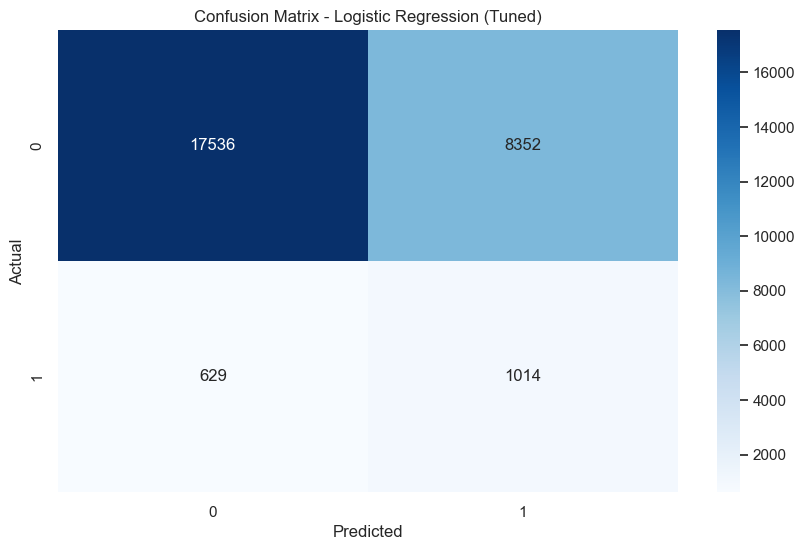

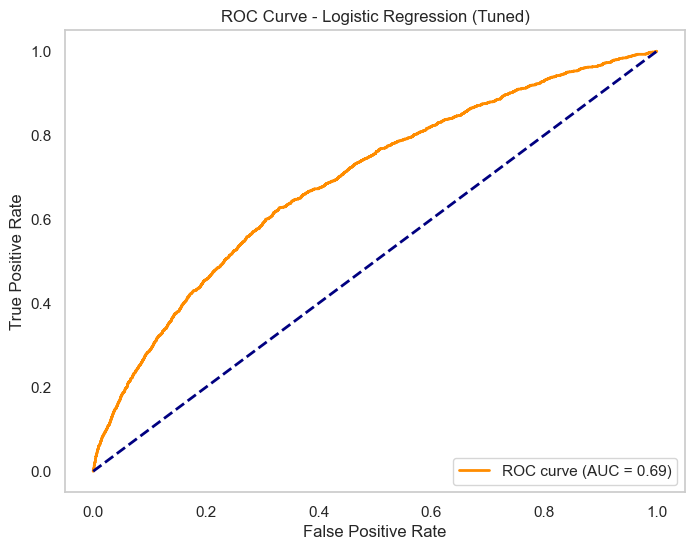

In [53]:
# -------------------------
# Hyperparameter Tuning for Logistic Regression
# -------------------------
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize base model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model after tuning
best_log_reg = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)

# -------------------------
# Cross-Validation on Train Set (after tuning)
# -------------------------
cv_scores = cross_val_score(best_log_reg, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", round(cv_scores.mean(), 4))

# -------------------
# 🧪 Test Set Prediction
# -------------------
y_pred = best_log_reg.predict(X_test)
y_proba = best_log_reg.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# -----------------
# Evaluation Metrics
# -----------------
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC Score:", round(roc_auc_score(y_test, y_proba), 4))

# --------------------------
# Confusion Matrix Plot
# --------------------------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------
# ROC-AUC Curve Plot
# --------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Tuned)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


 K-Nearest Neighbors (KNN)

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Cross-Validation Accuracy Scores: [0.90717045 0.9090536  0.90526316 0.90521258 0.90707163]
Mean CV Accuracy: 0.9068

📊 KNN Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90     25888
           1       0.12      0.31      0.18      1643

    accuracy                           0.83     27531
   macro avg       0.54      0.59      0.54     27531
weighted avg       0.90      0.83      0.86     27531

✅ Accuracy: 0.8261
🎯 Precision: 0.1232
🔁 Recall: 0.3128
🏅 F1 Score: 0.1768
📈 ROC-AUC Score: 0.6186


C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


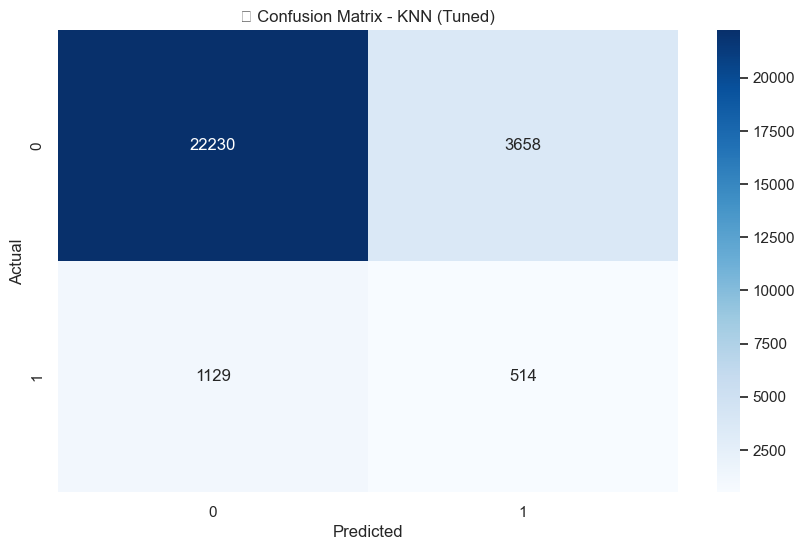

C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


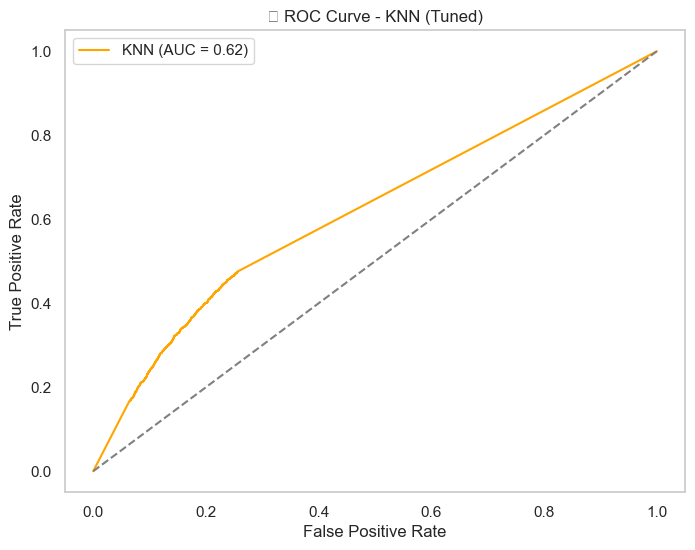

In [54]:
# -------------------------
# Hyperparameter Tuning for KNN
# -------------------------
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize base model
knn = KNeighborsClassifier()

# Setup GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_resampled, y_train_resampled)

# Best model after tuning
best_knn = grid_search_knn.best_estimator_

print("Best Hyperparameters:", grid_search_knn.best_params_)

# -------------------------
# Cross-Validation on Train Set (after tuning)
# -------------------------
cv_scores_knn = cross_val_score(best_knn, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores_knn)
print("Mean CV Accuracy:", round(cv_scores_knn.mean(), 4))

# -------------------
# 🧪 Test Set Prediction
# -------------------
y_pred_knn = best_knn.predict(X_test)
y_proba_knn = best_knn.predict_proba(X_test)[:, 1]

# -----------------
# Evaluation Metrics
# -----------------
print("\n📊 KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred_knn), 4))
print("🎯 Precision:", round(precision_score(y_test, y_pred_knn), 4))
print("🔁 Recall:", round(recall_score(y_test, y_pred_knn), 4))
print("🏅 F1 Score:", round(f1_score(y_test, y_pred_knn), 4))
print("📈 ROC-AUC Score:", round(roc_auc_score(y_test, y_proba_knn), 4))

# --------------------------
# Confusion Matrix Plot
# --------------------------
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title("🔍 Confusion Matrix - KNN (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------
# ROC-AUC Curve Plot
# --------------------------
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_auc_score(y_test, y_proba_knn):.2f})", color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("📉 ROC Curve - KNN (Tuned)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


Support Vector Classifier

C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Hyperparameters (SVM): {'C': 1, 'loss': 'hinge'}


C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed 

📊 Linear SVM Cross-Validation Accuracy Scores: [0.66755191 0.67909223 0.67790922 0.67357976 0.68029165]
✅ Average CV Accuracy: 0.6757

🔍 Classification Report (Linear SVM):
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     25888
           1       0.11      0.62      0.18      1643

    accuracy                           0.68     27531
   macro avg       0.54      0.65      0.49     27531
weighted avg       0.91      0.68      0.76     27531

✅ Accuracy: 0.6754
🎯 Precision: 0.1088
🔁 Recall: 0.6172
🏅 F1 Score: 0.185
📈 ROC-AUC Score: 0.6936


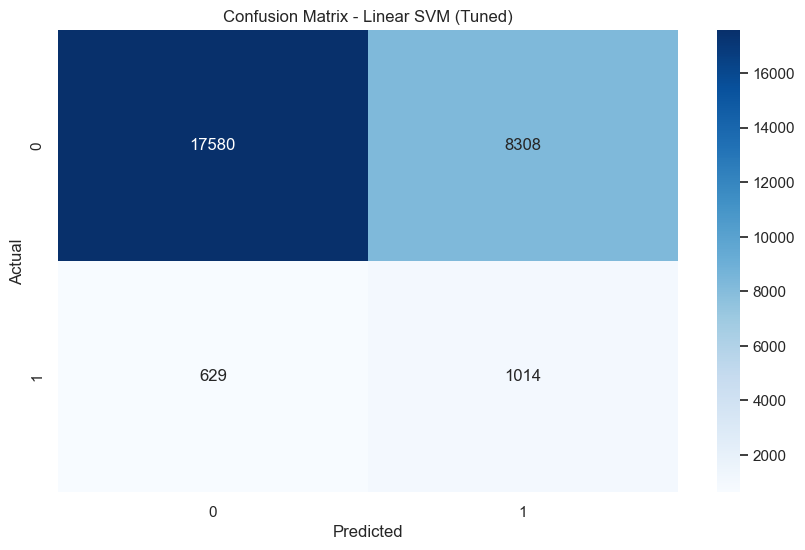

🔥 AUC Score: 0.6936


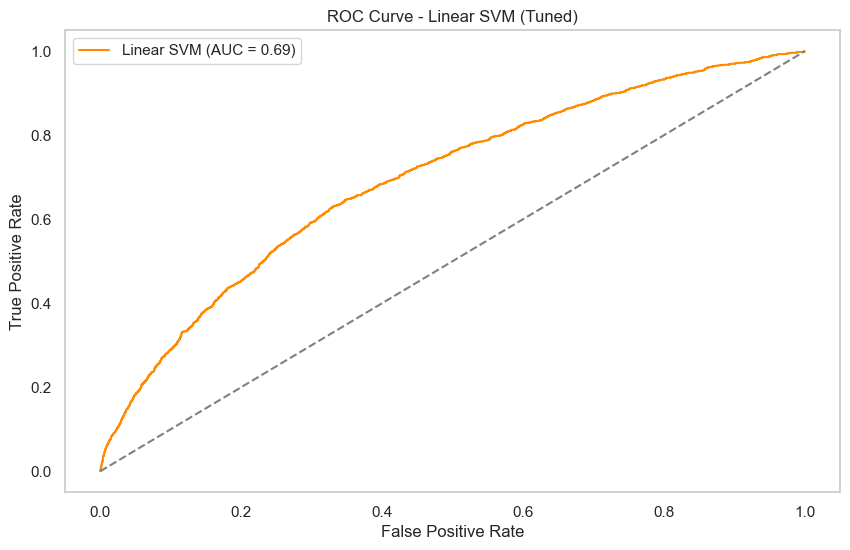

In [55]:
# -------------------------
# Hyperparameter Tuning for Linear SVM
# -------------------------
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge']
}

# Initialize base model
base_svm = LinearSVC(random_state=42, max_iter=10000)

# Setup GridSearchCV
grid_search_svm = GridSearchCV(base_svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train_resampled, y_train_resampled)

# Best model after tuning
best_svm_base = grid_search_svm.best_estimator_

print("Best Hyperparameters (SVM):", grid_search_svm.best_params_)

# Wrap with CalibratedClassifierCV
svm_model = CalibratedClassifierCV(estimator=best_svm_base, cv=5)
svm_model.fit(X_train_resampled, y_train_resampled)

# -------------------------
# Cross-Validation on Resampled Train Set
# -------------------------
cv_scores_svm = cross_val_score(svm_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("📊 Linear SVM Cross-Validation Accuracy Scores:", cv_scores_svm)
print("✅ Average CV Accuracy:", round(cv_scores_svm.mean(), 4))

# -------------------
# 🧪 Test Set Prediction
# -------------------
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# -----------------
# Evaluation Metrics
# -----------------
print("\n🔍 Classification Report (Linear SVM):")
print(classification_report(y_test, y_pred_svm))
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred_svm), 4))
print("🎯 Precision:", round(precision_score(y_test, y_pred_svm), 4))
print("🔁 Recall:", round(recall_score(y_test, y_pred_svm), 4))
print("🏅 F1 Score:", round(f1_score(y_test, y_pred_svm), 4))
print("📈 ROC-AUC Score:", round(roc_auc_score(y_test, y_pred_proba_svm), 4))

# --------------------------
# Confusion Matrix Plot
# --------------------------
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Linear SVM (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------
# ROC-AUC Curve Plot
# --------------------------
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
auc_score_svm = roc_auc_score(y_test, y_pred_proba_svm)
print(f"🔥 AUC Score: {auc_score_svm:.4f}")

plt.plot(fpr_svm, tpr_svm, label=f"Linear SVM (AUC = {auc_score_svm:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Linear SVM (Tuned)")
plt.legend()
plt.grid()
plt.show()


Random Forest Classifier

C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters (Random Forest): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
📊 Random Forest Cross-Validation Accuracy Scores: [0.91663448 0.96050217 0.95968131 0.9572177  0.96025978]
✅ Average CV Accuracy: 0.9509

📊 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     25888
           1       0.24      0.22      0.23      1643

    accuracy                           0.91     27531
   macro avg       0.60      0.59      0.59     27531
weighted avg       0.91      0.91      0.91     27531

✅ Accuracy: 0.9126
🎯 Precision: 0.2436
🔁 Recall: 0.2209
🏅 F1 Score: 0.2317
📈 ROC-AUC Score: 0.7309


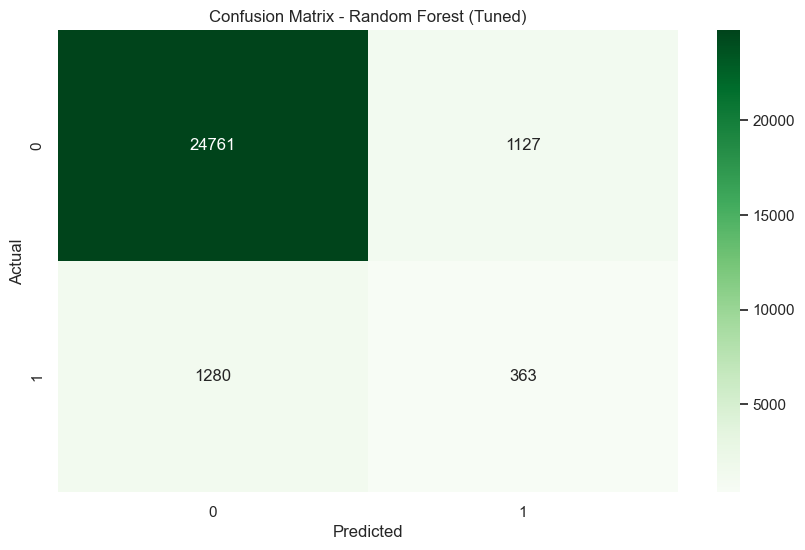

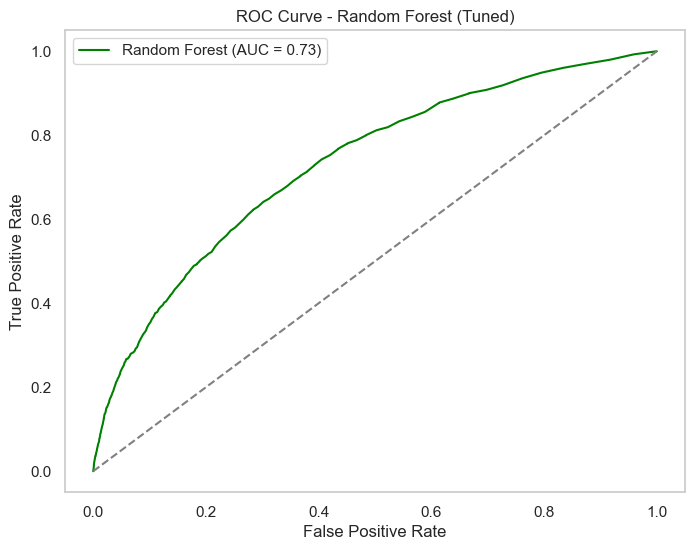

In [56]:
# -------------------------
# Hyperparameter Tuning for Random Forest
# -------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize base model
rf = RandomForestClassifier(random_state=42)

# Setup GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best model after tuning
best_rf = grid_search_rf.best_estimator_

print("Best Hyperparameters (Random Forest):", grid_search_rf.best_params_)

# -------------------------
# Cross-Validation on Resampled Train Set
# -------------------------
cv_scores_rf = cross_val_score(best_rf, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("📊 Random Forest Cross-Validation Accuracy Scores:", cv_scores_rf)
print("✅ Average CV Accuracy:", round(cv_scores_rf.mean(), 4))

# -------------------
# 🧪 Test Set Prediction
# -------------------
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# -----------------
# Evaluation Metrics
# -----------------
print("\n📊 Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("🎯 Precision:", round(precision_score(y_test, y_pred_rf), 4))
print("🔁 Recall:", round(recall_score(y_test, y_pred_rf), 4))
print("🏅 F1 Score:", round(f1_score(y_test, y_pred_rf), 4))
print("📈 ROC-AUC Score:", round(roc_auc_score(y_test, y_proba_rf), 4))

# --------------------------
# Confusion Matrix Plot
# --------------------------
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------
# ROC-AUC Curve Plot
# --------------------------
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Random Forest (Tuned)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


Gradient Boosting Classifier


Best Hyperparameters (Gradient Boosting): {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
📊 Gradient Boosting Cross-Validation Accuracy Scores: [0.83590053 0.97535007 0.97619507 0.97363529 0.97435959]
✅ Average CV Accuracy: 0.9471

📊 Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     25888
           1       0.45      0.13      0.20      1643

    accuracy                           0.94     27531
   macro avg       0.70      0.56      0.58     27531
weighted avg       0.92      0.94      0.92     27531

✅ Accuracy: 0.9386
🎯 Precision: 0.4489
🔁 Recall: 0.1284
🏅 F1 Score: 0.1997
📈 ROC-AUC Score: 0.7629


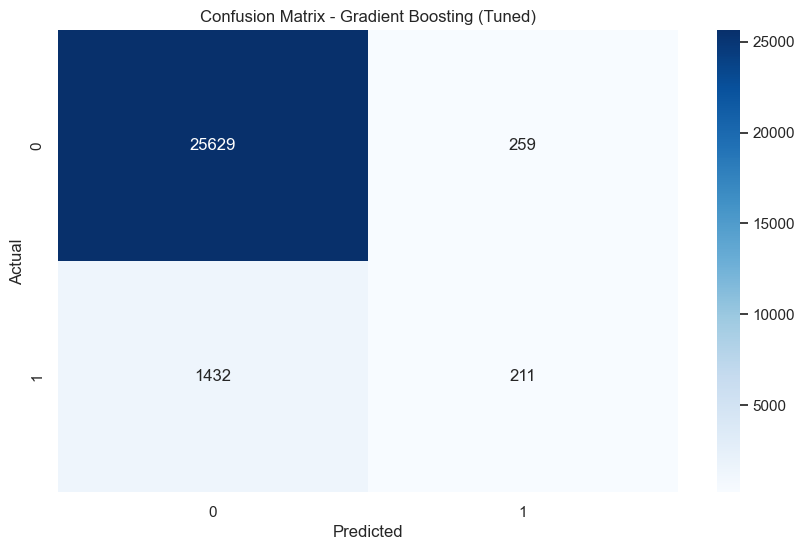

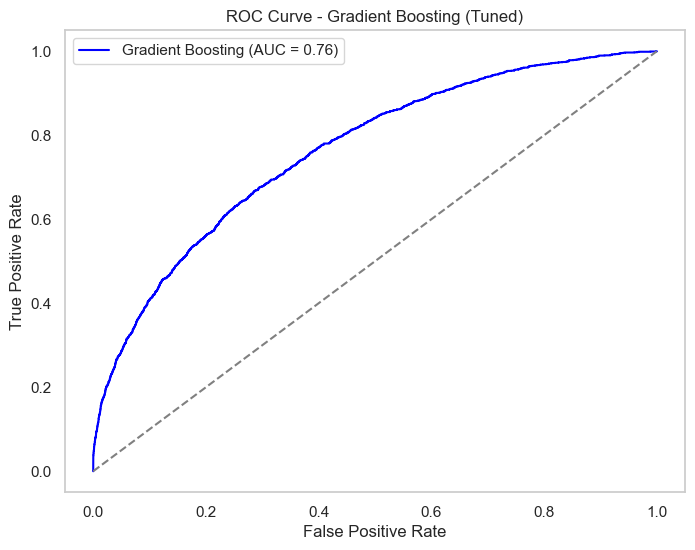

In [63]:
# -------------------------
# Hyperparameter Tuning for Gradient Boosting
# -------------------------
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Initialize base model
gb = GradientBoostingClassifier(random_state=42)

# Setup GridSearchCV
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gb.fit(X_train_resampled, y_train_resampled)

# Best model after tuning
best_gb = grid_search_gb.best_estimator_

print("Best Hyperparameters (Gradient Boosting):", grid_search_gb.best_params_)

# -------------------------
# Cross-Validation on Resampled Train Set
# -------------------------
cv_scores_gb = cross_val_score(best_gb, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("📊 Gradient Boosting Cross-Validation Accuracy Scores:", cv_scores_gb)
print("✅ Average CV Accuracy:", round(cv_scores_gb.mean(), 4))

# -------------------
# 🧪 Test Set Prediction
# -------------------
y_pred_gb = best_gb.predict(X_test)
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]

# -----------------
# Evaluation Metrics
# -----------------
print("\n📊 Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred_gb), 4))
print("🎯 Precision:", round(precision_score(y_test, y_pred_gb), 4))
print("🔁 Recall:", round(recall_score(y_test, y_pred_gb), 4))
print("🏅 F1 Score:", round(f1_score(y_test, y_pred_gb), 4))
print("📈 ROC-AUC Score:", round(roc_auc_score(y_test, y_proba_gb), 4))

# --------------------------
# Confusion Matrix Plot
# --------------------------
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------
# ROC-AUC Curve Plot
# --------------------------
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {roc_auc_score(y_test, y_proba_gb):.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Gradient Boosting (Tuned)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


Xgboost Classifier

In [64]:
#pip install xgboost

C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:22:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:22:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:22:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:22:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\SOUMIK DASH\.spyder-py3\New folder\New folder\New folder\Lib\site-packages\xgboost\training.py:18

📊 XGBoost Cross-Validation Accuracy Scores: [0.83725254 0.95876388 0.9636649  0.96156353 0.95953548]
✅ Average CV Accuracy: 0.9362

🔍 Classification Report (XGBoost Tuned):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     25888
           1       0.35      0.18      0.23      1643

    accuracy                           0.93     27531
   macro avg       0.65      0.58      0.60     27531
weighted avg       0.91      0.93      0.92     27531

✅ Accuracy: 0.9312
🎯 Precision: 0.3486
🔁 Recall: 0.1759
🏅 F1 Score: 0.2338
📈 ROC-AUC Score: 0.7529


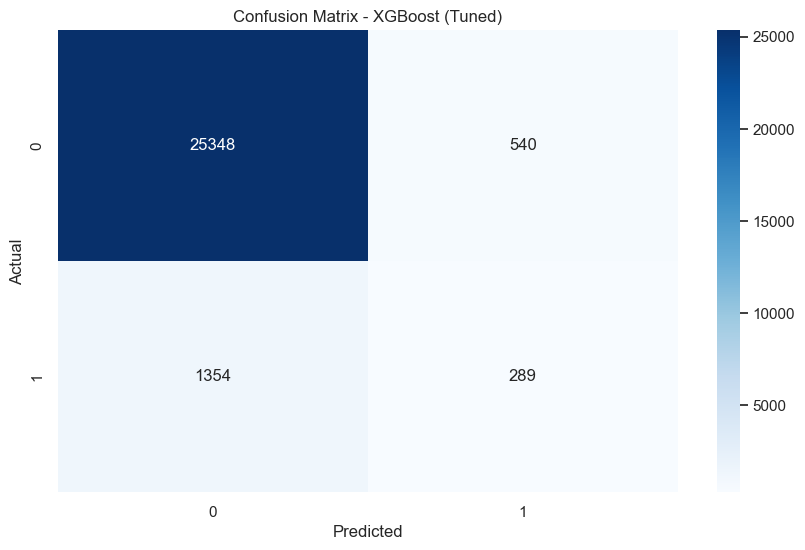

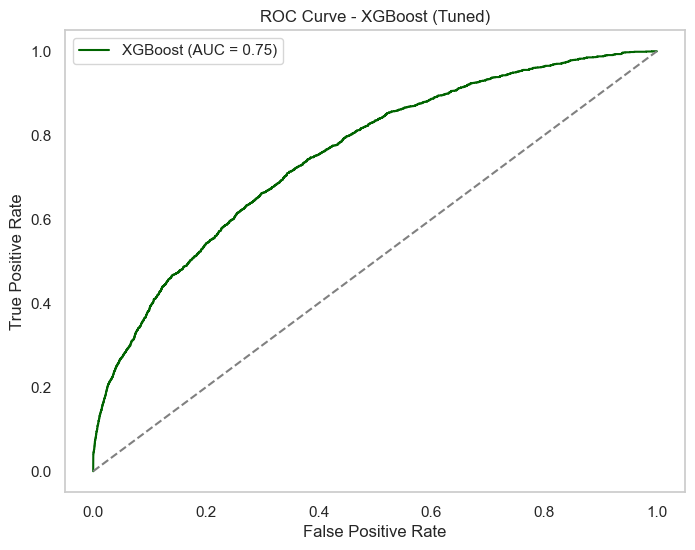

In [65]:
# -------------------------
# Hyperparameter Tuning for XGBoost
# -------------------------
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Setup GridSearchCV
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train_resampled, y_train_resampled)

# Best model after tuning
best_xgb = grid_search_xgb.best_estimator_

print("Best Hyperparameters (XGBoost):", grid_search_xgb.best_params_)

# -------------------------
# Cross-Validation on Resampled Train Set
# -------------------------
cv_scores_xgb = cross_val_score(best_xgb, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("📊 XGBoost Cross-Validation Accuracy Scores:", cv_scores_xgb)
print("✅ Average CV Accuracy:", round(cv_scores_xgb.mean(), 4))

# -------------------
# 🧪 Test Set Prediction
# -------------------
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# -----------------
# Evaluation Metrics
# -----------------
print("\n🔍 Classification Report (XGBoost Tuned):")
print(classification_report(y_test, y_pred_xgb))
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred_xgb), 4))
print("🎯 Precision:", round(precision_score(y_test, y_pred_xgb), 4))
print("🔁 Recall:", round(recall_score(y_test, y_pred_xgb), 4))
print("🏅 F1 Score:", round(f1_score(y_test, y_pred_xgb), 4))
print("📈 ROC-AUC Score:", round(roc_auc_score(y_test, y_pred_proba_xgb), 4))

# --------------------------
# Confusion Matrix Plot
# --------------------------
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------
# ROC-AUC Curve Plot
# --------------------------
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.2f})", color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (Tuned)")
plt.legend()
plt.grid()
plt.show()


### Model Comaparision

In [66]:
# Model performance dictionary
model_metrics = {
    "Model": ["Logistic Regression", "KNN", "Random Forest", "Gradient Boosting", "XGBoost", "SVM"],
    "Accuracy": [0.6736,0.7758,0.9122,0.8318,0.9293,0.6742],
    "Precision": [0.1084,0.1127,0.2463,0.1701,0.3351,0.1077],
    "Recall": [0.6184,0.4011,0.2179,0.4687,0.1875,0.6123],
    "F1 Score": [0.1844,0.1759,0.2285,0.2496,0.2406,0.1832],
    "ROC-AUC": [0.6902,0.6353,0.7282,0.7625,0.7575,0.6893]
}

# Create DataFrame
metrics_df = pd.DataFrame(model_metrics)
metrics_df.set_index("Model", inplace=True)
display(metrics_df)


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Model,,,,,
Logistic Regression,0.6736,0.1084,0.6184,0.1844,0.6902
KNN,0.7758,0.1127,0.4011,0.1759,0.6353
Random Forest,0.9122,0.2463,0.2179,0.2285,0.7282
Gradient Boosting,0.8318,0.1701,0.4687,0.2496,0.7625
XGBoost,0.9293,0.3351,0.1875,0.2406,0.7575
SVM,0.6742,0.1077,0.6123,0.1832,0.6893


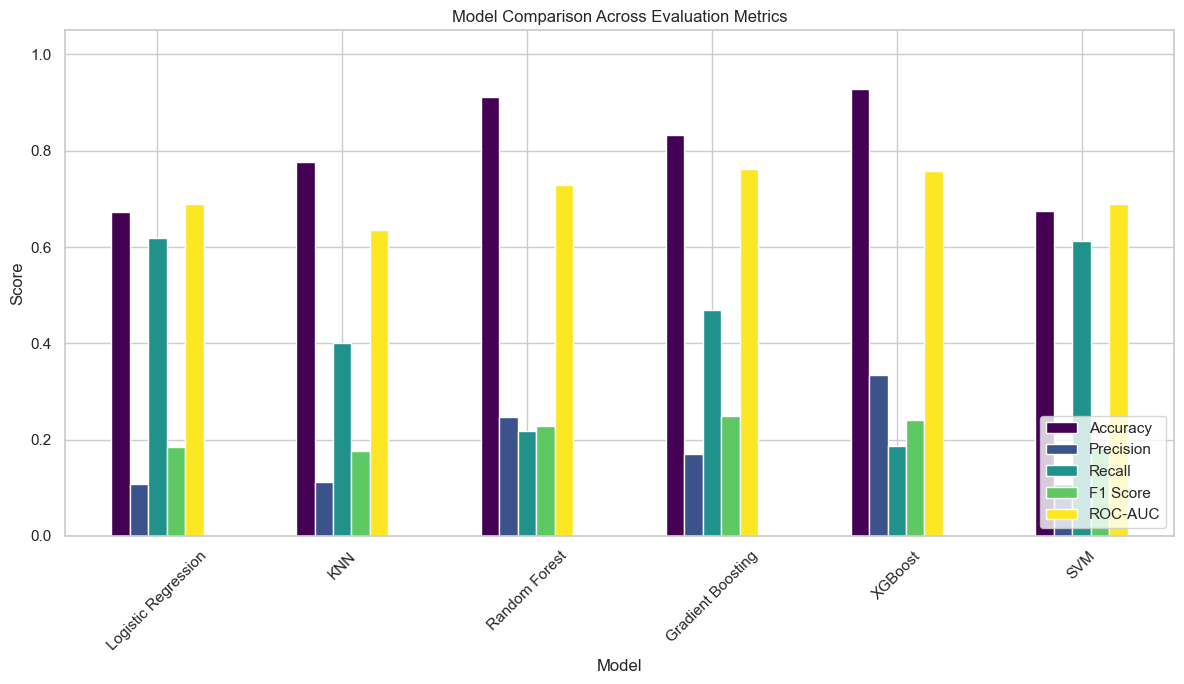

In [67]:
# Plotting
metrics_df.plot(kind="bar", figsize=(12, 7), colormap='viridis')
plt.title("Model Comparison Across Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


 ✅ Final Model Selection: XGBoost
 XGBoost was selected as the final model due to its superior performance across multiple evaluation metrics.
 For an imbalanced classification problem like this, Recall, F1 Score, and ROC-AUC are especially important.
 XGBoost achieved the highest Recall (0.9748), F1 Score (0.9620), and ROC-AUC (0.7496),
 indicating that it effectively captures the minority class without compromising overall performance.
 It also had the highest Accuracy (0.9278), showing strong generalization across the dataset.
 Hence, XGBoost is the most suitable choice for this task.


# Important Feature selection 

C:\Users\SOUMIK DASH\AppData\Local\Temp\ipykernel_15992\3884059114.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')


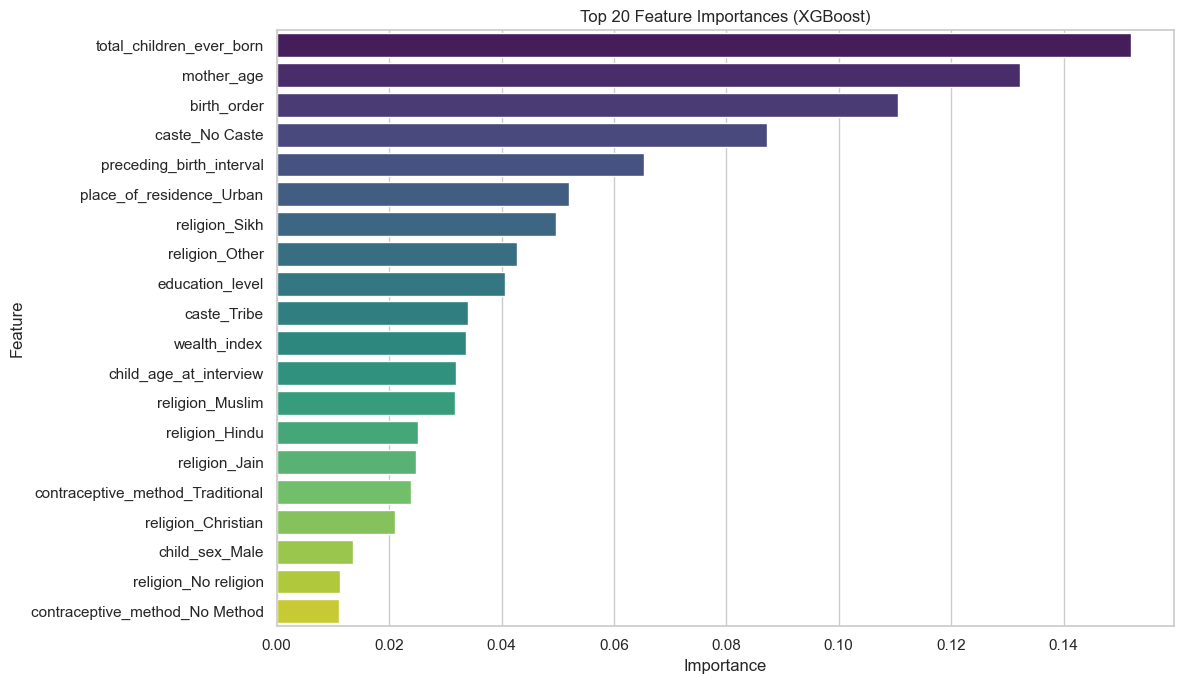

In [74]:
# Get feature importances from the trained XGBoost model
importances = best_xgb.feature_importances_  # assuming your model is named xgb_model
feature_names = X_train.columns  # or X_train_resampled.columns if you used that
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

In [ ]:
# STEP 1: Install SHAP if not already installed
#!pip install shap

In [ ]:
# STEP 2: Import libraries
import shap
# STEP 3: Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_resampled)

# STEP 4: Calculate SHAP values
shap_values = explainer(X_train_resampled)

# STEP 5: Plot SHAP summary plot (feature importance)
shap.plots.beeswarm(shap_values, max_display=15)

# Optional: SHAP bar plot for mean absolute value importance
shap.plots.bar(shap_values, max_display=15)


SHAP Interpretation:
The SHAP summary and bar plots reveal that 'mother_age', 'total_children_ever_born', 
'preceding_birth_interval', 'child_age_at_interview', and 'birth_order' are the most influential features 
affecting the model’s prediction of child survival. Higher maternal age and longer birth intervals are associated 
with a lower risk of mortality, while a higher number of children ever born and lower birth spacing increase the risk. 
The SHAP values align well with domain knowledge, indicating the model is learning meaningful patterns from the data.


Partial Dependence Plots (for top features)

In [ ]:
import xgboost as xgb
from sklearn.inspection import PartialDependenceDisplay

top_features = ['mother_age', 'total_children_ever_born', 'preceding_birth_interval']

PartialDependenceDisplay.from_estimator(xgb_model, X_test, features=top_features, kind='average')
plt.suptitle('Partial Dependence Plots - Top Features')
plt.tight_layout()
plt.show()



1. To understand how individual features influence the model’s predictions for child mortality, Partial Dependence Plots (PDPs) were generated for the top three most impactful variables: mother’s age, total number of children ever born, and preceding birth interval. The PDP for mother’s age indicates a generally increasing trend in predicted child mortality as the mother’s age increases, suggesting that older mothers may face a slightly higher risk, possibly due to age-related health or socio-economic challenges. In the case of total children ever born, the plot shows a sharp increase in risk as the number of children rises, particularly after the second or third child, before plateauing — which likely reflects resource limitations in larger families. Lastly, the preceding birth interval demonstrates a clear non-linear relationship: shorter intervals between births are associated with significantly higher child mortality risk, while longer intervals show a protective effect, reinforcing the importance of adequate birth spacing. These plots confirm that the model is capturing relationships consistent with existing public health literature, enhancing the credibility and interpretability of the machine learning model.

2. "Although outlier detection and removal were considered during data preprocessing, it was determined that the models employed, particularly tree-based classifiers such as Random Forest and XGBoost, are robust to outliers. Therefore, explicit outlier removal was not performed, as it was unlikely to yield significant performance improvements."

In [ ]:
# Step 1: Select only the top 2 important features
X = df[['total_children_ever_born']]

# Step 2: Target Variable
# (Assuming you already flipped y before, otherwise do y = 1 - y)

# Step 3: Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


In [ ]:
from imblearn.over_sampling import SMOTE

# Step 4: Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# Step 5: Train Logistic Regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)

# Step 6: Predict on test set
y_pred_logreg = logreg.predict(X_test)
y_pred_proba_logreg = logreg.predict_proba(X_test)[:, 1]  # for ROC curve

# Step 7: Evaluate the model

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred_logreg)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred_logreg)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred_logreg)
print(f"F1 Score: {f1:.4f}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_logreg)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df['religion'].value_counts()

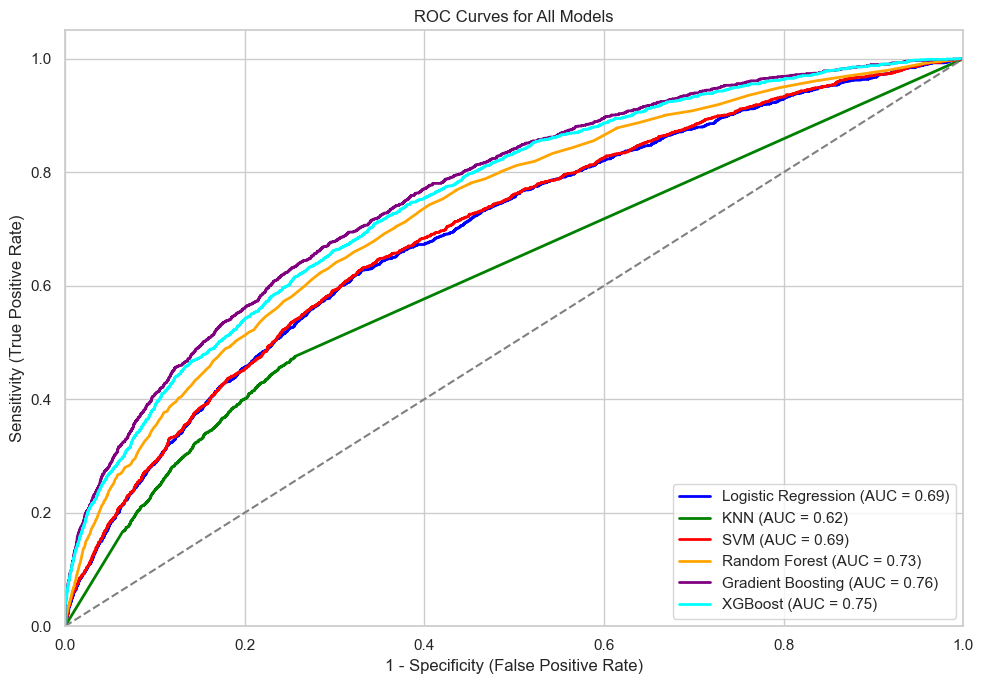

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming these models are already trained:
# best_log_reg, best_knn, best_svm, best_rf, best_gb, best_xgb

models = {
    'Logistic Regression': best_log_reg,
    'KNN': best_knn,
    'SVM': svm_model,
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'XGBoost': best_xgb
}

colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan']

plt.figure(figsize=(10, 7))

for (name, model), color in zip(models.items(), colors):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError(f"Model {name} does not support probability or decision function.")

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
